# Partially/Purely Relational SET Classification: RESOLVE vs Baselines

In [1]:
import sys
sys.path.append('../..'); sys.path.append('../');

import numpy as np
import matplotlib.pyplot as plt
from setGame import *
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import utils

2024-09-17 15:01:02.869352: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-17 15:01:05.796530: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 15:01:05.796619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 15:01:06.195995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 15:01:07.033845: I tensorflow/core/platform/cpu_feature_guar

In [2]:
setgame = SetGame()

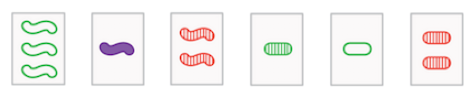

[0 3 4]


In [3]:
num_cards=6
_ = setgame.init_state(num_cards=num_cards, shuffle=False)
hand = setgame.state.dealt_cards
fig, axarr = plt.subplots(1, len(hand), figsize=(len(hand)*1,1))
pi = np.random.choice(range(len(hand)), size=len(hand), replace=False)
for i in range(len(hand)):
    card = hand[i]
    axarr[i].imshow(setgame.image_of_card(card[0], card[1]))
    axarr[i].axis('off')
plt.show()
print(np.sort(np.argsort(pi)[0:3]))


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from sklearn.model_selection import train_test_split

class SetEmbedder():
    def __init__(self, ff_dim1=128, ff_dim2=64):
        img_input = layers.Input(shape=(70, 50, 4))
        x = layers.Conv2D(8, (5, 5), activation='tanh')(img_input)
        x = layers.MaxPooling2D((8,8))(x)
        x = layers.Conv2D(8, (5, 5), activation='relu')(x)
        #x = layers.MaxPooling2D((2,2))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(ff_dim1, activation='relu')(x)
        x = layers.Dense(ff_dim2, activation='tanh')(x)
        outputs = layers.Dense(12, activation='sigmoid')(x)
        self.model = Model(inputs=img_input, outputs=outputs)
        self.embed = Model(self.model.input, self.model.layers[2].output)   # change the self.model.layers[2] to layers[-1] to get purely relational task
        self.model.summary()
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
        self.model_initial_weights = self.model.get_weights()

    def train(self, X_train, y_train, epochs=2):
        self.model.set_weights(self.model_initial_weights)
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

    def predict(self, X_test):
        out = self.model.predict(X_test, verbose=0)
        return out

    def embed(self, X_test):
        out = self.embed(X_test, verbose=0)
        return out

In [6]:
def convert_to_binary(attrs):
    color = {'red':[1,0,0], 'green':[0,1,0], 'purple':[0,0,1]}
    pattern = {'empty':[1,0,0], 'striped':[0,1,0], 'solid':[0,0,1]}
    shape = {'diamond':[1,0,0], 'oval':[0,1,0], 'squiggle':[0,0,1]}
    number = {'one':[1,0,0], 'two':[0,1,0], 'three':[0,0,1]}
    binary_attrs = number[attrs[0]] + color[attrs[1]] + pattern[attrs[2]] + shape[attrs[3]]
    return binary_attrs

n = 1000
X = np.empty((n, 70, 50, 4), dtype=np.float32)
y = np.empty((n, 12), dtype=int)

card_coord = [(i,j) for i in np.arange(9) for j in np.arange(9)]
for i in np.arange(n):
    c = np.random.choice(np.arange(81), size=1)[0]
    (row, col) = card_coord[c]
    attrs = setgame.attributes_of_card(row, col)
    binary_attrs = convert_to_binary(attrs)
    X[i] = setgame.image_of_card(row, col)
    y[i] = binary_attrs


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
cnn = SetEmbedder(ff_dim1=64, ff_dim2=64)
cnn.train(X_train, y_train, epochs=50)


2024-09-17 15:01:48.450822: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-17 15:01:49.638220: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-17 15:01:49.638527: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 50, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 66, 46, 8)         808       
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 5, 8)           0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 1, 8)           1608      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                             

2024-09-17 15:01:51.737581: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-09-17 15:01:57.601160: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9208535710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-17 15:01:57.601201: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-09-17 15:01:57.743191: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1726599718.017121    5206 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - 10s 10ms/step - loss: 0.6561 - binary_accuracy: 0.6214
Epoch 2/50
24/24 [==============================] - 0s 2ms/step - loss: 0.6323 - binary_accuracy: 0.6667
Epoch 3/50
24/24 [==============================] - 0s 5ms/step - loss: 0.6040 - binary_accuracy: 0.6801
Epoch 4/50
24/24 [==============================] - 0s 5ms/step - loss: 0.5163 - binary_accuracy: 0.7560
Epoch 5/50
24/24 [==============================] - 0s 5ms/step - loss: 0.4460 - binary_accuracy: 0.7781
Epoch 6/50
24/24 [==============================] - 0s 4ms/step - loss: 0.3993 - binary_accuracy: 0.8048
Epoch 7/50
24/24 [==============================] - 0s 2ms/step - loss: 0.3620 - binary_accuracy: 0.8280
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.3315 - binary_accuracy: 0.8501
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.3036 - binary_accuracy: 0.8643
Epoch 10/50
24/24 [==============================] - 0s 3ms/step

In [9]:
for i in range(5):
    j = np.random.choice(range(X_test.shape[0]))
    pred = np.round(cnn.predict(X_test[j:(j+1)]))[0]
    pred = [int(pred[b]) for b in range(len(pred))]
    print(list(pred))
    print(list(y_test[j:(j+1)][0]))
    print('\n')

[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0]


[0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0]
[0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0]


[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]


[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]


[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]
[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]




In [10]:
out = cnn.predict(X_test)
pred = np.array(np.round(out), dtype=int)
1-np.sum(pred != y_test) / (np.prod(pred.shape))


1.0

## SET Classification Task

In [11]:
def create_set_classification_dataset(num_seqs):

    vocab_size = 81
    setgame = SetGame()
    dim = cnn.embed(np.expand_dims(setgame.image_of_card(0, 0), axis=0)).numpy().squeeze().shape
    print(dim)
    # generate random features for each object
    card_images = np.zeros((9, 9, dim[0]*dim[1]*dim[2]))
    for i in range(9):
        for j in range(9):
            card_images[i,j] = cnn.embed(np.expand_dims(setgame.image_of_card(i, j), axis=0)).numpy().squeeze().flatten()

    object_seqs = np.zeros((num_seqs, 3, dim[0]*dim[1]*dim[2]))
    card_seqs = np.zeros((num_seqs, 3, 2), dtype=int)
    labels = np.zeros(num_seqs, dtype=int)

    for s in np.arange(0, num_seqs, 2):
        _ = setgame.init_state(num_cards=6, shuffle=False)
        hand = setgame.state.dealt_cards
        for i in np.arange(3):
            card = hand[i]
            object_seqs[s, i] = card_images[card[0], card[1]]
            card_seqs[s, i] = [card[0], card[1]]
        labels[s] = 1
        for i in np.arange(3):
            card = hand[i+3]
            object_seqs[s+1, i] = card_images[card[0], card[1]]
            card_seqs[s+1, i] = [card[0], card[1]]
        labels[s+1] = 0

    return card_images, card_seqs, labels, object_seqs,

In [12]:
card_images, card_seqs, labels, object_seqs = create_set_classification_dataset(num_seqs=10000)

(8, 5, 8)


In [13]:
print(card_images.shape)
print(card_seqs.shape)
print(labels.shape)
print(object_seqs.shape)

(9, 9, 320)
(10000, 3, 2)
(10000,)
(10000, 3, 320)


In [14]:
test_size = 0.2
val_size = 0.1

seqs_train, seqs_test, object_seqs_train, object_seqs_test, labels_train, labels_test = train_test_split(card_seqs, object_seqs, labels, test_size=0.2)

seqs_train, seqs_val, object_seqs_train, object_seqs_val, labels_train, labels_val = \
train_test_split(seqs_train, object_seqs_train, labels_train, test_size=val_size/(1-test_size))

X_train, X_val, X_test = object_seqs_train, object_seqs_val, object_seqs_test
y_train, y_val, y_test = labels_train, labels_val, labels_test

In [15]:
X_train.shape, y_train.shape

((7000, 3, 320), (7000,))

In [16]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam()

def create_callbacks():
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc', restore_best_weights=True, patience=50, start_from_epoch=30)]
    return callbacks


In [17]:
class ConvLayerWithLearnableH(tf.keras.layers.Layer):
    def __init__(self, h_size):
        super(ConvLayerWithLearnableH, self).__init__()
        # Initialize h as a trainable variable
        self.h_size = h_size
    def build(self, input_shape):
        self.h = self.add_weight(shape=(3, self.h_size), initializer='random_normal', trainable=True)
    def call(self, x_batch):
        S = 3

        def convolve_step(i):
            # Flip the impulse response h[n] for proper convolution
            h_flipped = tf.reverse(self.h[i,:], axis=[0])

            # Pad each signal in the batch to allow for full convolution
            padded_x_batch = tf.pad(x_batch[:, i, :], [[0, 0], [960, 960]])

            # Reshape both signals for 1D convolution
            x_batch_reshaped = tf.reshape(padded_x_batch, [tf.shape(padded_x_batch)[0], -1, 1])  # Shape: (batch_size, signal_length, 1)
            h_reshaped = tf.reshape(h_flipped, [-1, 1, 1])  # Reshape filter (kernel) after flipping

            # Perform 1D convolution using VALID padding for each signal in the batch
            y_batch = tf.nn.conv1d(x_batch_reshaped, h_reshaped, stride=1, padding='VALID')

            # Reshape the result back to 2D (batch_size, output_length)
            return tf.squeeze(y_batch)

        # Use tf.map_fn to apply the convolution step over the sequence dimension
        output = tf.map_fn(convolve_step, tf.range(S), dtype=tf.float32)

        # Transpose the output tensor to ensure the correct shape (batch_size, S, output_length)
        output = tf.transpose(output, perm=[1, 0, 2])

        return output


class SmallConvNet(tf.keras.Model):
    def __init__(self):
        super(SmallConvNet, self).__init__()
        #self.conv1 = layers.Conv1D(filters=64, kernel_size=3, padding='same')
        self.encoder = ConvLayerWithLearnableH( h_size=1024-64+1)
        self.dropout = layers.Dropout(0.2)
        self.ln1 = layers.LayerNormalization()
        #self.ln2 = layers.BatchNormalization()

    def call(self, x):
        #x = self.conv1(x)
        #x = tf.nn.silu(x)
        #x = self.ln2(x)
        x = self.encoder(x) 
        x = self.ln1(x)
        x = tf.nn.silu(x)    
        x = self.dropout(x, training=True)
        return x


class HDSymbolicAttention(layers.Layer):
    def __init__(self, d_model, embd_size, training, symbolic, name="hd_symbolic_attention", **kwargs):
        super(HDSymbolicAttention, self).__init__(name=name, **kwargs)
        self.d_model = d_model
        self.embd_size = embd_size
        self.symbolic = symbolic
        self.process = SmallConvNet()
        
    def cosine_similarity(self, a, b):
        dot_product = tf.reduce_mean(tf.math.sign(a) * tf.math.sign(b), axis=-1) 
        return dot_product

    def create_cosine_similarity_matrix(self, X,C):
        X_i_expanded = X[:, tf.newaxis, :, :]  
        X_j_expanded = C[:, :, tf.newaxis, :]  
        X_i_plus_X_j = X_i_expanded + X_j_expanded  

        S = self.cosine_similarity(X_i_expanded, X_i_plus_X_j)
          
        return tf.nn.softmax(S,axis=-1)

    def build(self, input_shape):
        normal_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.Symbols = tf.Variable(normal_initializer(shape=(3, self.embd_size)), name='symbols', trainable=True)
        super(HDSymbolicAttention, self).build(input_shape)

    def call(self, values):
        self.S3 = tf.zeros_like(values)
        values_projected = self.process(values)
        symbol_projected = self.process(self.S3 +self.Symbols)   

        #values_projected = tf.nn.tanh(tf.einsum('bij,jk->bik',values,hd_encoder))
        if self.symbolic:
            scores = self.create_cosine_similarity_matrix(values_projected,symbol_projected)
        else:
            scores = self.create_cosine_similarity_matrix(values_projected,values_projected) 
        attention_output = tf.matmul(scores,values_projected)
        O = tf.nn.swish(attention_output*symbol_projected)
        return O

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], self.d_model)

## RESOLVE Module

In [18]:
from transformer_modules import Encoder, Decoder, AddPositionalEmbedding
from abstracters import SymbolicAbstracter, RelationalAbstracter

class RESOLVE(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff, embedding_dim, training, symbolic, dropout_rate=0.1):
        super(RESOLVE, self).__init__()
        
        self.source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.fc = layers.Dense(64, activation='relu')
        self.mha = HDSymbolicAttention(1024, 64,training = training, symbolic = symbolic)
        self.flattener = layers.Flatten()
        self.dropout = layers.Dropout(0.1)
        self.bn1 = layers.Normalization()
        self.bn2 = layers.BatchNormalization()
        self.final_layer = layers.Dense(1, name='final_layer', activation='sigmoid')

    def call(self, inputs):
        x = self.source_embedder(inputs)
        x = self.pos_embedding_adder_input(x)
        x = self.encoder(x)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.mha(x) 
        x = self.bn1(x)
        x = self.flattener(x)
        x = self.final_layer(x)
        return x

In [19]:


transformer_model = RESOLVE(num_layers=2, num_heads=4, dff=64, embedding_dim=64, dropout_rate=0.1, training=True, symbolic=False)
transformer_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
transformer_model(X_train[:32]); # build
transformer_model.summary()

Model: "nvsa"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistr  multiple                  20544     
 ibuted)                                                         
                                                                 
 add_pos_embedding_input (A  multiple                  0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  149888    
                                                                 
 dense_4 (Dense)             multiple                  4160      
                                                                 
 hd_symbolic_attention (HDS  multiple                  5123      
 ymbolicAttention)                                               
                                                              

In [25]:
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
accuracies = []
seeds = [2020, 2021, 2022, 2023, 2024]
for seed in tqdm(seeds):
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=seed)
    seed_accuracies = []
    for train_size in range(500, 2000, 400):
        X_train_ = X_train_shuffled[:train_size]
        y_train_ = y_train_shuffled[:train_size]
        model = RESOLVE(num_layers=2, num_heads=4, dff=64, embedding_dim=64, dropout_rate=0.1, training=True, symbolic=False)
        model(X_train[:32])
        model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['acc'])
        print(X_train_.shape)
        model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=100, verbose=0, batch_size=512, callbacks=create_callbacks())
        results = model.evaluate(X_test, y_test, return_dict=True)
        seed_accuracies.append(results['acc'])
    accuracies.append(seed_accuracies)
accuracies_np = np.array(accuracies)
np.save('./low_preprocessing/accuracies.npy', accuracies_np)
mean_accuracy = np.mean(accuracies_np)
print(f"Mean accuracy over all seeds: {mean_accuracy}")


  0%|                                                     | 0/5 [00:00<?, ?it/s]

(500, 3, 320)
63/63 [==============================] - 0s 7ms/step - loss: 0.6213 - acc: 0.7885
(900, 3, 320)
63/63 [==============================] - 0s 7ms/step - loss: 0.3898 - acc: 0.8415
(1300, 3, 320)
63/63 [==============================] - 0s 8ms/step - loss: 0.3702 - acc: 0.8440
(1700, 3, 320)
63/63 [==============================] - 0s 7ms/step - loss: 0.3736 - acc: 0.8460


 20%|█████████                                    | 1/5 [00:51<03:27, 51.81s/it]

(500, 3, 320)
63/63 [==============================] - 0s 7ms/step - loss: 0.8241 - acc: 0.7830
(900, 3, 320)
63/63 [==============================] - 0s 7ms/step - loss: 0.3800 - acc: 0.8435
(1300, 3, 320)
63/63 [==============================] - 0s 6ms/step - loss: 0.3788 - acc: 0.8365
(1700, 3, 320)
63/63 [==============================] - 0s 6ms/step - loss: 0.3674 - acc: 0.8455


 40%|██████████████████                           | 2/5 [01:41<02:31, 50.62s/it]

(500, 3, 320)
63/63 [==============================] - 0s 6ms/step - loss: 0.5527 - acc: 0.8030
(900, 3, 320)
63/63 [==============================] - 0s 7ms/step - loss: 0.3706 - acc: 0.8455
(1300, 3, 320)
63/63 [==============================] - 0s 7ms/step - loss: 0.3729 - acc: 0.8435
(1700, 3, 320)
63/63 [==============================] - 0s 6ms/step - loss: 0.3689 - acc: 0.8435


 60%|███████████████████████████                  | 3/5 [02:34<01:42, 51.44s/it]

(500, 3, 320)
63/63 [==============================] - 0s 5ms/step - loss: 0.3959 - acc: 0.8445
(900, 3, 320)
63/63 [==============================] - 0s 7ms/step - loss: 0.4245 - acc: 0.8350
(1300, 3, 320)
63/63 [==============================] - 0s 5ms/step - loss: 0.3877 - acc: 0.8385
(1700, 3, 320)
63/63 [==============================] - 0s 6ms/step - loss: 0.3722 - acc: 0.8465


 80%|████████████████████████████████████         | 4/5 [03:30<00:53, 53.34s/it]

(500, 3, 320)
63/63 [==============================] - 0s 5ms/step - loss: 0.4032 - acc: 0.8130
(900, 3, 320)
63/63 [==============================] - 0s 7ms/step - loss: 0.3711 - acc: 0.8455
(1300, 3, 320)
63/63 [==============================] - 0s 7ms/step - loss: 0.3728 - acc: 0.8455
(1700, 3, 320)
63/63 [==============================] - 0s 6ms/step - loss: 0.3693 - acc: 0.8455


100%|█████████████████████████████████████████████| 5/5 [04:19<00:00, 51.90s/it]

Mean accuracy over all seeds: 0.833899998664856


## Abstractor

In [26]:
from transformer_modules import Encoder, Decoder, AddPositionalEmbedding
from abstracters import RelationalAbstracter
from abstractor import Abstractor

def create_abstractor(encoder_kwargs, abstractor_kwargs, embedding_dim, dropout_rate=0.1, name='abstractor'):
    inputs = layers.Input(shape=object_seqs_train.shape[1:], name='input_seq')
    object_embedder = tf.keras.Sequential([layers.Dense(embedding_dim)])
    source_embedder = layers.TimeDistributed(object_embedder, name='source_embedder')
    pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
    #if encoder_kwargs:
    encoder = Encoder(**encoder_kwargs, name='encoder')
    abstractor = RelationalAbstracter(**abstractor_kwargs, name='abstractor')
    flattener = layers.Flatten()
    final_layer = layers.Dense(1, name='final_layer',activation='sigmoid')
    fc = layers.Dense(64,activation='relu')
    
    x = source_embedder(inputs)
    x = source_embedder(inputs)
    x = pos_embedding_adder_input(x)
    x = encoder(x)
    x = fc(x)   
    x = abstractor(x)
    x = flattener(x)
    logits = final_layer(x)

    abstractor_model = tf.keras.Model(inputs=inputs, outputs=logits, name=name)
    return abstractor_model

In [27]:

encoder_kwargs = dict(num_layers=2, num_heads=4, dff=64, dropout_rate=0.1)
abstractor_kwargs = dict(num_layers=2, num_heads=4, dff=64,
     use_pos_embedding=True, mha_activation_type='softmax', dropout_rate=0.1)

abstractor_model_kwargs = dict(encoder_kwargs=encoder_kwargs, abstractor_kwargs=abstractor_kwargs, embedding_dim=64)
abstractor_model = create_abstractor(**abstractor_model_kwargs)

abstractor_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
abstractor_model(X_train[:32]); # build
abstractor_model.summary()

Model: "abstractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 3, 320)]          0         
                                                                 
 source_embedder (TimeDistr  (None, 3, 64)             20544     
 ibuted)                                                         
                                                                 
 add_pos_embedding_input (A  (None, 3, 64)             0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           (None, 3, 64)             149888    
                                                                 
 dense_418 (Dense)           (None, 3, 64)             4160      
                                                                 
 abstractor (RelationalAbst  (None, 3, 64)             1

In [28]:
import numpy as np
from sklearn.utils import shuffle
accuracies = []
seeds = [2020, 2021, 2022, 2023, 2024]
for seed in tqdm(seeds):
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=seed)
    seed_accuracies = []
    for train_size in range(500, 2000, 400):
        X_train_ = X_train_shuffled[:train_size]
        y_train_ = y_train_shuffled[:train_size]
        transformer_model = create_abstractor(**abstractor_model_kwargs)
        transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['acc'])
        transformer_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=100, verbose=0, batch_size=512, callbacks=create_callbacks())
        results = transformer_model.evaluate(X_test, y_test, return_dict=True)
        seed_accuracies.append(results['acc'])
    accuracies.append(seed_accuracies)
accuracies_np = np.array(accuracies)
np.save('./low_preprocessing/accuracies_abstractor.npy', accuracies_np)
mean_accuracy = np.mean(accuracies_np)
print(f"Mean accuracy over all seeds: {mean_accuracy}")

  0%|                                                     | 0/5 [00:00<?, ?it/s]

63/63 [==============================] - 0s 5ms/step - loss: 0.4591 - acc: 0.8055


 20%|█████████                                    | 1/5 [00:39<02:36, 39.02s/it]

63/63 [==============================] - 0s 5ms/step - loss: 0.3939 - acc: 0.8380


 40%|██████████████████                           | 2/5 [01:20<02:01, 40.51s/it]

63/63 [==============================] - 0s 5ms/step - loss: 0.3638 - acc: 0.8460


 60%|███████████████████████████                  | 3/5 [01:59<01:19, 39.65s/it]

63/63 [==============================] - 0s 6ms/step - loss: 0.4230 - acc: 0.8275


 80%|████████████████████████████████████         | 4/5 [02:38<00:39, 39.70s/it]

63/63 [==============================] - 0s 4ms/step - loss: 0.3794 - acc: 0.8430


100%|█████████████████████████████████████████████| 5/5 [03:18<00:00, 39.64s/it]

Mean accuracy over all seeds: 0.7418749988079071


In [29]:
from transformer_modules import Encoder, Decoder, AddPositionalEmbedding
from abstracters import RelationalAbstracter
from abstractor import Abstractor

def create_transformer(encoder_kwargs, embedding_dim, dropout_rate=0.1, name='abstractor'):
    inputs = layers.Input(shape=object_seqs_train.shape[1:], name='input_seq')
    object_embedder = tf.keras.Sequential([layers.Dense(embedding_dim)])
    source_embedder = layers.TimeDistributed(object_embedder, name='source_embedder')
    pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
    encoder = Encoder(**encoder_kwargs, name='encoder')
    flattener = layers.Flatten()
    final_layer = layers.Dense(1, name='final_layer',activation='sigmoid')
    fc = layers.Dense(64,activation='relu')
    
    x = source_embedder(inputs)
    x = source_embedder(inputs)
    x = pos_embedding_adder_input(x)
    x = encoder(x)
    x = fc(x)   
    x = flattener(x)
    logits = final_layer(x)

    abstractor_model = tf.keras.Model(inputs=inputs, outputs=logits, name=name)
    return abstractor_model



encoder_kwargs = dict(num_layers=2, num_heads=4, dff=64, dropout_rate=0.1)
import numpy as np
from sklearn.utils import shuffle
accuracies = []
seeds = [2020, 2021, 2022, 2023, 2024]
for seed in tqdm(seeds):
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=seed)
    seed_accuracies = []
    for train_size in range(500, 2000, 400):
        X_train_ = X_train_shuffled[:train_size]
        y_train_ = y_train_shuffled[:train_size]
        transformer_model = create_transformer(encoder_kwargs, embedding_dim=64)
        transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['acc'])
        transformer_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=100, verbose=0, batch_size=512, callbacks=create_callbacks())
        results = transformer_model.evaluate(X_test, y_test, return_dict=True)
        seed_accuracies.append(results['acc'])
    accuracies.append(seed_accuracies)
accuracies_np = np.array(accuracies)
np.save('./low_preprocessing/accuracies_transformer.npy', accuracies_np)
mean_accuracy = np.mean(accuracies_np)
print(f"Mean accuracy over all seeds: {mean_accuracy}")


  0%|                                                     | 0/5 [00:00<?, ?it/s]

63/63 [==============================] - 0s 2ms/step - loss: 0.3715 - acc: 0.8445


 20%|█████████                                    | 1/5 [00:22<01:30, 22.58s/it]

63/63 [==============================] - 0s 4ms/step - loss: 0.3801 - acc: 0.8405


 40%|██████████████████                           | 2/5 [00:49<01:14, 24.92s/it]

63/63 [==============================] - 0s 4ms/step - loss: 0.3638 - acc: 0.8415


 60%|███████████████████████████                  | 3/5 [01:12<00:48, 24.05s/it]

63/63 [==============================] - 0s 3ms/step - loss: 0.3854 - acc: 0.8295


 80%|████████████████████████████████████         | 4/5 [01:35<00:23, 23.84s/it]

63/63 [==============================] - 0s 2ms/step - loss: 0.4356 - acc: 0.8030


100%|█████████████████████████████████████████████| 5/5 [01:59<00:00, 23.92s/it]

Mean accuracy over all seeds: 0.8211250007152557


## CorelNet

In [30]:
from multi_head_relation import MultiHeadRelation

def create_corelnet(embedding_dim, activation='softmax', name='corelnet'):
    inputs = layers.Input(shape=object_seqs_train.shape[1:], name='input_seq')
    object_embedder = tf.keras.Sequential([layers.Dense(embedding_dim)])
    source_embedder = layers.TimeDistributed(object_embedder, name='source_embedder')
    activation = layers.Softmax(axis=1) if activation == 'softmax' else layers.Activation(activation)
    mhr = MultiHeadRelation(rel_dim=1, proj_dim=None, symmetric=True, dense_kwargs=dict(use_bias=False))
    flattener = layers.Flatten()
    final_layer = layers.Dense(2, name='final_layer')

    x = source_embedder(inputs)
    x = mhr(x)
    x = activation(x)
    x = flattener(x)
    logits = final_layer(x)

    corelnet_model = tf.keras.Model(inputs=inputs, outputs=logits, name=name)
    return corelnet_model

In [31]:
from multi_head_relation import MultiHeadRelation

def create_mlp(embedding_dim, activation='softmax', name='corelnet'):
    inputs = layers.Input(shape=object_seqs_train.shape[1:], name='input_seq')
    object_embedder = tf.keras.Sequential([layers.Dense(embedding_dim)])
    source_embedder = layers.TimeDistributed(object_embedder, name='source_embedder')
    flattener = layers.Flatten()
    final_layer = layers.Dense(2, name='final_layer')

    x = source_embedder(inputs)
    x = flattener(x)
    logits = final_layer(x)

    corelnet_model = tf.keras.Model(inputs=inputs, outputs=logits, name=name)
    return corelnet_model

In [32]:

import numpy as np
from sklearn.utils import shuffle
accuracies = []
seeds = [2020, 2021, 2022, 2023, 2024]
for seed in tqdm(seeds):
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=seed)
    seed_accuracies = []
    for train_size in range(500, 2000, 400):
        X_train_ = X_train_shuffled[:train_size]
        y_train_ = y_train_shuffled[:train_size]
        corelnet_model_kwargs = dict(embedding_dim=64, activation='softmax')
        corelnet_model_nosoftmax_kwargs = dict(embedding_dim=64, activation='linear')
        transformer_model = create_mlp(**corelnet_model_nosoftmax_kwargs)
        transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['acc'])
        transformer_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=100, verbose=0, batch_size=512, callbacks=create_callbacks())
        results = transformer_model.evaluate(X_test, y_test, return_dict=True)
        seed_accuracies.append(results['acc'])
    accuracies.append(seed_accuracies)
accuracies_np = np.array(accuracies)
np.save('./low_preprocessing/accuracies_mlp.npy', accuracies_np)
mean_accuracy = np.mean(accuracies_np)
print(f"Mean accuracy over all seeds: {mean_accuracy}")

  0%|                                                     | 0/5 [00:00<?, ?it/s]

63/63 [==============================] - 0s 579us/step - loss: 7.6707 - acc: 0.5240


 20%|█████████                                    | 1/5 [00:07<00:30,  7.74s/it]

63/63 [==============================] - 0s 799us/step - loss: 7.6707 - acc: 0.5240


 40%|██████████████████                           | 2/5 [00:15<00:23,  7.78s/it]

63/63 [==============================] - 0s 575us/step - loss: 7.6634 - acc: 0.4760


 60%|███████████████████████████                  | 3/5 [00:23<00:15,  7.76s/it]

63/63 [==============================] - 0s 543us/step - loss: 8.0827 - acc: 0.4960


 80%|████████████████████████████████████         | 4/5 [00:30<00:07,  7.63s/it]

63/63 [==============================] - 0s 759us/step - loss: 8.0827 - acc: 0.4760


100%|█████████████████████████████████████████████| 5/5 [00:38<00:00,  7.67s/it]

Mean accuracy over all seeds: 0.49647499769926073


In [19]:
corelnet_model_kwargs = dict(embedding_dim=64, activation='softmax')
corelnet_model_nosoftmax_kwargs = dict(embedding_dim=64, activation='linear')
corelnet_model = create_corelnet(**corelnet_model_nosoftmax_kwargs)
corelnet_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
corelnet_model(X_train[:32]); # build
corelnet_model.summary()

Model: "corelnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 3, 320)]          0         
                                                                 
 source_embedder (TimeDistr  (None, 3, 64)             20544     
 ibuted)                                                         
                                                                 
 multi_head_relation (Multi  (None, 3, 1)              4096      
 HeadRelation)                                                   
                                                                 
 activation (Activation)     (None, 3, 1)              0         
                                                                 
 flatten_46 (Flatten)        (None, 3)                 0         
                                                                 
 final_layer (Dense)         (None, 2)                 8  

In [33]:

import numpy as np
from sklearn.utils import shuffle
accuracies = []
seeds = [2020, 2021, 2022, 2023, 2024]
for seed in tqdm(seeds):
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=seed)
    seed_accuracies = []
    for train_size in range(500, 2000, 400):
        X_train_ = X_train_shuffled[:train_size]
        y_train_ = y_train_shuffled[:train_size]
        corelnet_model_kwargs = dict(embedding_dim=64, activation='softmax')
        corelnet_model_nosoftmax_kwargs = dict(embedding_dim=64, activation='linear')
        transformer_model = create_corelnet(**corelnet_model_nosoftmax_kwargs)
        transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['acc'])
        transformer_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=100, verbose=0, batch_size=512, callbacks=create_callbacks())
        results = transformer_model.evaluate(X_test, y_test, return_dict=True)
        seed_accuracies.append(results['acc'])
    accuracies.append(seed_accuracies)
accuracies_np = np.array(accuracies)
np.save('./low_preprocessing/accuracies_correlnet.npy', accuracies_np)
mean_accuracy = np.mean(accuracies_np)
print(f"Mean accuracy over all seeds: {mean_accuracy}")

  0%|                                                     | 0/5 [00:00<?, ?it/s]

63/63 [==============================] - 0s 882us/step - loss: 7.4708 - acc: 0.4765


 20%|█████████                                    | 1/5 [00:09<00:37,  9.40s/it]

63/63 [==============================] - 0s 709us/step - loss: 7.6707 - acc: 0.5240


 40%|██████████████████                           | 2/5 [00:18<00:27,  9.02s/it]

63/63 [==============================] - 0s 1ms/step - loss: 7.6707 - acc: 0.4760


 60%|███████████████████████████                  | 3/5 [00:26<00:17,  8.85s/it]

63/63 [==============================] - 0s 2ms/step - loss: 7.6707 - acc: 0.5240


 80%|████████████████████████████████████         | 4/5 [00:35<00:08,  8.83s/it]

63/63 [==============================] - 0s 689us/step - loss: 7.8777 - acc: 0.4760


100%|█████████████████████████████████████████████| 5/5 [00:43<00:00,  8.79s/it]

Mean accuracy over all seeds: 0.4939000025391579


In [38]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

class PrediNet(tf.keras.layers.Layer):
    """PrediNet layer (Shanahan et al. 2020)"""

    def __init__(self, key_dim, n_heads, n_relations, add_temp_tag=False):
        """create PrediNet layer.

        Parameters
        ----------
        key_dim : int
            key dimension
        n_heads : int
            number of heads
        n_relations : int
            number of relations
        add_temp_tag : bool, optional
            whether to add temporal tag to object representations, by default False
        """

        super(PrediNet, self).__init__()
        self.key_dim = key_dim
        self.n_heads = n_heads
        self.n_relations = n_relations
        self.add_temp_tag = add_temp_tag

    def build(self, input_shape):
        _, self.n_objs, obj_dim = input_shape

        self.obj_dim = obj_dim
        self.obj_tagged_dim = self.obj_dim + 1

        self.W_k = layers.Dense(self.key_dim, use_bias=False)
        self.W_q1 = layers.Dense(self.n_heads * self.key_dim, use_bias=False)
        self.W_q2 = layers.Dense(self.n_heads * self.key_dim, use_bias=False)
        self.W_s = layers.Dense(self.n_relations, use_bias=False)

        self.relu = layers.ReLU()
        self.softmax = layers.Softmax(axis=1)
        self.flatten = layers.Flatten()

        # create temporal tag
        if self.add_temp_tag:
            self.temp_tag = tf.convert_to_tensor(np.arange(self.n_objs), dtype=tf.float32)
            self.temp_tag = tf.expand_dims(self.temp_tag, axis=0)
            self.temp_tag = tf.expand_dims(self.temp_tag, axis=2)


    def call(self, obj_seq):

        # append temporal tag to all z
        if self.add_temp_tag:
            temp_tag = tf.tile(self.temp_tag, multiples=[tf.shape(obj_seq)[0], 1, 1])
            obj_seq = tf.concat([obj_seq, temp_tag], axis=2)

        # Get keys for all objects in sequence
        K = self.W_k(obj_seq)

        # get queries for objects 1 and 2
        obj_seq_flat = self.flatten(obj_seq)
        Q1 = self.W_q1(obj_seq_flat)
        Q2 = self.W_q2(obj_seq_flat)

        # reshape queries to separate heads
        Q1_reshaped = tf.reshape(Q1, shape=(-1, self.n_heads, self.key_dim))
        Q2_reshaped = tf.reshape(Q2, shape=(-1, self.n_heads, self.key_dim))

        # extract attended objects
        E1 = (self.softmax(tf.reduce_sum(Q1_reshaped[:, tf.newaxis, :, :] * K[:, :, tf.newaxis, :], axis=3))
             [:, :, :, tf.newaxis] * obj_seq[:, :, tf.newaxis, :])
        E1 = tf.reduce_sum(E1, axis=1)
        E2 = (self.softmax(tf.reduce_sum(Q2_reshaped[:, tf.newaxis, :, :] * K[:, :, tf.newaxis, :], axis=3))
              [:, :, :, tf.newaxis] * obj_seq[:, :, tf.newaxis, :])
        E2 = tf.reduce_sum(E2, axis=1)

        # compute relation vector
        D = self.W_s(E1) - self.W_s(E2)

        # add temporal position tag
        if self.add_temp_tag:
            D = tf.concat([D, E1[:, :, -1][:, :, tf.newaxis], E2[:, :, -1][:, :, tf.newaxis]], axis=2)

        R = self.flatten(D) # concatenate heads

        return R

In [49]:
def create_predinet(encoder_kwargs, embedding_dim, dropout_rate=0.1, name='predinet'):
    inputs = layers.Input(shape=object_seqs_train.shape[1:], name='input_seq')
    object_embedder = tf.keras.Sequential([layers.Dense(embedding_dim)])
    source_embedder = layers.TimeDistributed(object_embedder, name='source_embedder')
    pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
    #if encoder_kwargs:
    encoder = Encoder(**encoder_kwargs, name='encoder')
    predinet = PrediNet(key_dim=64, n_heads=1 ,n_relations= 1, add_temp_tag=False)
    flattener = layers.Flatten()
    # hidden_dense = layers.Dense(64, activation='relu', name='hidden_dense')
    final_layer = layers.Dense(1, name='final_layer',activation='sigmoid')
    fc = layers.Dense(64,activation='relu')
    
    x = source_embedder(inputs)
    x = source_embedder(inputs)
    x = pos_embedding_adder_input(x)
    x = encoder(x)
    x = predinet(x)
    x = fc(x)   
    x = flattener(x)
    logits = final_layer(x)

    abstractor_model = tf.keras.Model(inputs=inputs, outputs=logits, name=name)
    return abstractor_model

In [50]:
import numpy as np
from sklearn.utils import shuffle
accuracies = []
seeds = [2020, 2021, 2022, 2023, 2024]
for seed in tqdm(seeds):
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=seed)
    seed_accuracies = []
    for train_size in range(500, 2000, 400):
        X_train_ = X_train_shuffled[:train_size]
        y_train_ = y_train_shuffled[:train_size]
        encoder_kwargs = dict(num_layers=2, num_heads=4, dff=64, dropout_rate=0.1)
        transformer_model = create_predinet(encoder_kwargs, embedding_dim=64)
        transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['acc'])
        transformer_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=100, verbose=0, batch_size=512, callbacks=create_callbacks())
        results = transformer_model.evaluate(X_test, y_test, return_dict=True)
        seed_accuracies.append(results['acc'])
    accuracies.append(seed_accuracies)
accuracies_np = np.array(accuracies)
np.save('./low_preprocessing/accuracies_predinet.npy', accuracies_np)
mean_accuracy = np.mean(accuracies_np)
print(f"Mean accuracy over all seeds: {mean_accuracy}")

  0%|                                                     | 0/5 [00:00<?, ?it/s]

63/63 [==============================] - 0s 3ms/step - loss: 0.3949 - acc: 0.8430


 20%|█████████                                    | 1/5 [00:28<01:53, 28.30s/it]

63/63 [==============================] - 0s 3ms/step - loss: 0.3718 - acc: 0.8455


 40%|██████████████████                           | 2/5 [00:57<01:25, 28.62s/it]

63/63 [==============================] - 0s 4ms/step - loss: 0.3937 - acc: 0.8390


 60%|███████████████████████████                  | 3/5 [01:24<00:56, 28.17s/it]

63/63 [==============================] - 0s 3ms/step - loss: 0.4487 - acc: 0.8035


 80%|████████████████████████████████████         | 4/5 [01:53<00:28, 28.39s/it]

63/63 [==============================] - 0s 4ms/step - loss: 0.7001 - acc: 0.4760


100%|█████████████████████████████████████████████| 5/5 [02:20<00:00, 28.18s/it]

Mean accuracy over all seeds: 0.8013499975204468


In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the MLP used to process the input feature vectors
def build_mlp(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    return model

# Define the adapted Logic Embedding Network for binary output
def build_len_binary(input_shape):
    # MLP model to process each of the input feature vectors (shape: (320,))
    mlp_model = build_mlp((320,))
    
    # Input for the single feature vector (shape: (3, 320))
    input_tensor = layers.Input(shape=(3, 320))
    
    # Split the input tensor into 3 separate tensors of shape (320,)
    input1, input2, input3 = tf.split(input_tensor, num_or_size_splits=3, axis=1)
    
    # Squeeze the tensors to remove extra dimensions (from (1, 320) to (320,))
    input1 = tf.squeeze(input1, axis=1)
    input2 = tf.squeeze(input2, axis=1)
    input3 = tf.squeeze(input3, axis=1)

    # Compute embeddings for each of the input vectors
    embedding1 = mlp_model(input1)
    embedding2 = mlp_model(input2)
    embedding3 = mlp_model(input3)
    
    # Concatenate embeddings and pass them through another dense layer
    concatenated = layers.Concatenate()([embedding1, embedding2, embedding3])
    reasoning_output = layers.Dense(64, activation='relu')(concatenated)
    reasoning_output = layers.Dense(32, activation='relu')(reasoning_output)
    
    # Output layer with sigmoid activation for binary classification
    output = layers.Dense(1, activation='sigmoid')(reasoning_output)
    
    # Build the model
    model = models.Model(inputs=input_tensor, outputs=output)
    return model

# Example input shape and number of feature vectors
input_shape = (3, 320)  # 3 feature vectors of size 320 each
len_binary_model = build_len_binary(input_shape)
# Build the LEN model for binary output

len_binary_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 3, 320)]             0         []                            
                                                                                                  
 tf.split (TFOpLambda)       [(None, 1, 320),             0         ['input_2[0][0]']             
                              (None, 1, 320),                                                     
                              (None, 1, 320)]                                                     
                                                                                                  
 tf.compat.v1.squeeze (TFOp  (None, 320)                  0         ['tf.split[0][0]']            
 Lambda)                                                                                    

In [35]:
import numpy as np
from sklearn.utils import shuffle
accuracies = []
seeds = [2020, 2021, 2022, 2023, 2024]
for seed in tqdm(seeds):
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=seed)
    seed_accuracies = []
    for train_size in range(500, 2000, 400):
        X_train_ = X_train_shuffled[:train_size]
        y_train_ = y_train_shuffled[:train_size]
        transformer_model = build_len_binary(input_shape)
        transformer_model.compile(optimizer=create_opt(), loss='binary_crossentropy', metrics=['acc'])
        transformer_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=100, verbose=0, batch_size=512, callbacks=create_callbacks())
        results = transformer_model.evaluate(X_test, y_test, return_dict=True)
        seed_accuracies.append(results['acc'])
    accuracies.append(seed_accuracies)
accuracies_np = np.array(accuracies)
np.save('./low_preprocessing/accuracies_LEN.npy', accuracies_np)
mean_accuracy = np.mean(accuracies_np)
print(f"Mean accuracy over all seeds: {mean_accuracy}")


  0%|                                                     | 0/5 [00:00<?, ?it/s]

63/63 [==============================] - 0s 1ms/step - loss: 0.3813 - acc: 0.8345


 20%|█████████                                    | 1/5 [00:11<00:45, 11.25s/it]

63/63 [==============================] - 0s 834us/step - loss: 0.3853 - acc: 0.8405


 40%|██████████████████                           | 2/5 [00:22<00:34, 11.38s/it]

63/63 [==============================] - 0s 798us/step - loss: 0.5282 - acc: 0.7555


 60%|███████████████████████████                  | 3/5 [00:33<00:22, 11.24s/it]

63/63 [==============================] - 0s 731us/step - loss: 0.4319 - acc: 0.8080


 80%|████████████████████████████████████         | 4/5 [00:45<00:11, 11.44s/it]

63/63 [==============================] - 0s 857us/step - loss: 0.3893 - acc: 0.8405


100%|█████████████████████████████████████████████| 5/5 [00:57<00:00, 11.42s/it]

Mean accuracy over all seeds: 0.7987250030040741
